# RandomForest Model interpretation

Based on summary of models, we selected `no_tempinc.csv_w3` since it had the best r-squared and error metrics for both RandomForest and XGB models. This input did not use the created temperature increase variables, but did incorporate the sampling weights.

We will begin by generating the RandomForest model using our selected input. In the process we also incorporated a column of random numbers, with the intent of flagging any features that fall below the importance of a random numbers column.

In [2]:
#Necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# annoying warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [3]:
#Functions to be utilized through analysis:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

def mae(rf, X_val, y_val):
    return mean_absolute_error(y_val, rf.predict(X_val))

def r2(rf, X_val, y_val):
    return r2_score(y_val, rf.predict(X_val))

def mse(rf, X_val, y_val):
    return mean_squared_error(y_val, rf.predict(X_val))
        
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)

In [4]:
#Create RandomForest model again:
#Set the random seed to match original model creations:
np.random.seed(42)

#Read in the best input:
df = pd.read_csv('p_data/no_tempinc.csv')
df.drop(['Unnamed: 0', 'CampaignID'], axis = 1, inplace = True)

train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

#Incorporate sampling weighing of 3 for the training set:
train = oversample_extremes(train, low_weight=3, high_weight = 3)

y_train = train['Quality']
train.drop(['Quality'], axis = 1, inplace = True)
X_train = train
X_train['Random'] = np.random.random(size=len(X_train))

y_val = val['Quality']
val.drop(['Quality'], axis = 1, inplace = True)
X_val = val
X_val['Random'] = np.random.random(size=len(X_val))

y_test = test['Quality']
test.drop(['Quality'], axis = 1, inplace = True)
X_test = test
X_test['Random'] = np.random.random(size=len(X_test))

rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                min_samples_split = 9,min_samples_leaf = 4,
                min_weight_fraction_leaf= 0.0)

rf_fit = rf_reg.fit(X_train, y_train)
rf_reg_preds_val = rf_fit.predict(X_val)
rf_reg_preds_test = rf_fit.predict(X_test)

mae_score = mean_absolute_error(y_test, rf_reg_preds_test)
mse_score = mean_squared_error(y_test, rf_reg_preds_test)
r_squared = r2_score(y_test, rf_reg_preds_test)
print("Test set R2:",round(r_squared,3))
print("Test set MAE:",round(mae_score,3))
print("Test set MSE:",round(mse_score,3))

mae_score = mean_absolute_error(y_val, rf_reg_preds_val)
mse_score = mean_squared_error(y_val, rf_reg_preds_val)
r_squared = r2_score(y_val, rf_reg_preds_val)
print("Validation set R2:",round(r_squared,3))
print("Validation set MAE:",round(mae_score,3))
print("Validation set MSE:",round(mse_score,3))


Test set R2: 0.346
Test set MAE: 0.962
Test set MSE: 2.389
Validation set R2: 0.548
Validation set MAE: 0.801
Validation set MSE: 1.476


Now that we have re-generated the RandomForest model we can start deciphering the model. To do this, we will analyse the feature importances using two methods:
1. The default RandomForest feature_importance: this is a built-in attribute in the RandomForest algorithm. While it is useful and computationally efficient, it is prone to bias, as per our investigations (https://explained.ai/rf-importance/). 
2. Permutation importance: to address the bias issue, and to compare across multiple models, we elected to also analyze the permutation importance of our features. This method is model-agnostic, so it allows for a good comparison with XGB model.

### Default RandomForest feature_importance analysis

We start by generating the default feature importance report from our RandomForest model and sorting by most important feature.

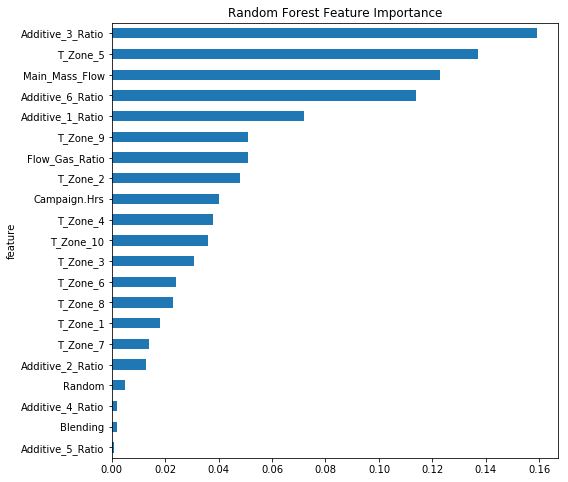

In [5]:
#Obtain feature importances from the model result and join back to features:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_reg.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Feature Importance")
#Reasonable results, random column is at the lower end of the scale

The top 5 most important features are reported to be `Additive_1_Ratio`, `Additive_3_Ratio`, `Additive_6_Ratio`, `Main_Mass_Flow`, and `T_Zone_5`. Intuitively, these make sense: the additive ratios capture the chemistry of the process, the mass flow captures the mass balance, and the temperature variable captures the energy balance. We are reasonably happy with these results, as the model appears to represent the fundamentals of the process. As we expected, the `Random` variable is at the bottom end of the scale, and based on `Additive_4_Ratio`, `Additive_5_Ratio`, and `Blending` variables below it, it appears they do not significantly contribute to the `Quality` variable in our process.

It's also important to note that three of the top five most important features are the additive ratios. Based on this result the RandomForest model is emphasizing the importance of chemistry in this process, over perhaps energy or material balance components.

It's important to highlight the bias issue with the default feature importance methodology above. As per the cited article, it tends to inflate the importance of continuous variables (in this case Main_Mass_Flow). To address this, and for better comparison to the XGB model, we analyze the permutation importance next.

### Permutation importance analysis

We begin by defining a function that will generate the permutation importance values for each feature, and apply it to our model.

In [6]:
def JBAFPI(rf, x_data, y_data, metric):
    """This function performs the permutation importance approach for model interpretation.
    The metric is the scoring function with which feature importances are calculated."""
    baseline = metric(rf,x_data,y_data)
    Importance = []
    feature = []
    for col in x_data.columns:
        save = x_data[col].copy()
        x_data[col] = np.random.permutation(x_data[col])
        m = metric(rf,x_data,y_data)
        x_data[col] = save
        Importance.append((m-baseline))
        feature.append(col)
    return pd.DataFrame({'Importance':Importance,'Feature':feature}).set_index("Feature")

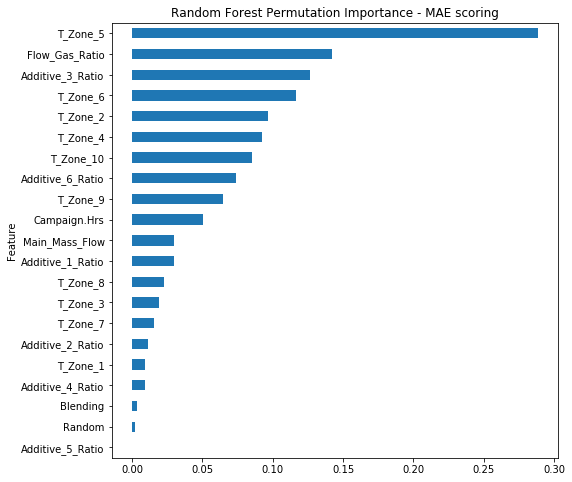

In [9]:
np.random.seed(42) 
perm_imp_JBAFPI = JBAFPI(rf_reg, X_val, y_val, mae)
# display(perm_imp_JBAFPI)
perm_imp_JBAFPI = perm_imp_JBAFPI.sort_values('Importance',ascending=True)
perm_imp_JBAFPI.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance - MAE scoring")

Based on permutation importance, the top five most important features are `T_Zone_2`, `T_Zone_5`, `T_Zone_6`, `Additive_3_Ratio`, and `Flow_Gas_Ratio`. These variables still capture the process fundamentals of energy and material balance, as well as the chemistry. However it emphasizes the energy balance as the most important contributor to the `Quality` variable, and highlights that perhaps the RandomForest feature importance was being biased by the continuous nature of `Main_Mass_Flow`. 

In terms of the least important features, not much has changed. While the `Random` variable is now lower in importance, there's still the same variables at the bottom of the list. 

### Comparison of XGB and RandomForest interpretation results

At this point, we decided to compare the permutation importances of XGB and RandomForest models to gain insight on our process and determine which variables have the most impact on `Quality` variable.

It is immediately evident based on the top five important variables identified in each model that `T_Zone_2` and `T_Zone_6` have significant impact on `Quality`; `T_Zone_5` was ranked sixth by the XGB model so it also is likely a contributor to the outcome of the process. This also stresses the importance of energy balance in the process. 

With regards to the material balance , the models can't seem to agree which of `Main_Mass_Flow` and `Flow_Gas_Ratio` are important. This is likely a gap in our design, as we only provided two variables relating to material balance.

In terms of the chemistry aspects of the process, the models start to diverge and tell conflicting stories. The additive ratio ranks do not agree, and the worse example of this is `Additive_3_ratio` which is ranked in the top 5 in RandomForest, but the lowest in the XGB model. At this point one would rely on the domain knowledge to determine if one model is making a critical error over the other. For example, is the additive just inert gas? In that case, we can confidently say the RandomForest model is erroneous as we do not expect any impact to `Quality` from inert components. Without intimate knowledge of the process, we cannot definitively determine why the models are diverging here. 

